In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

sns.set_style('ticks')

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Завдання

## 1. Огляд даних

### 1.1 Про що дані

В цій лабораторній роботі я працюю з даними про пісні із стримінгового сервісу [Spotify](https://open.spotify.com/). Про кожну пісню ми, окрім її назви та автора, знаємо низку показників як от популярність, акустичність, інструментальність ітд.

Завдання класифікації полягає в тому щоб класифікувати до якого, з 10 жанрів, належить пісня: `'Electronic', 'Anime', 'Jazz', 'Alternative', 'Country', 'Rap', 'Blues', 'Rock', 'Classical', 'Hip-Hop'`.

Дані можна знайти [тут](https://www.kaggle.com/datasets/vicsuperman/prediction-of-music-genre)

In [2]:
df = pd.read_csv('music_genre.csv')
df.head()

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic


## 2. Обробка даних

In [3]:
# drop unneeded columns
cols = ['instance_id', 'artist_name', 'track_name', 'obtained_date', 'popularity', 'key']
df.drop(cols, axis=1, inplace=True)

# remove rows with nan values
df.dropna(inplace=True)

# convert mode to numerical column
df['mode'] = df['mode'].replace({'Minor': 0, 'Major': 1})

# replace missing values in duration and tempo columns
# with a mean value in this column
duration_mean = df.loc[df['duration_ms'] != -1, 'duration_ms'].mean()
df['duration_ms'].replace(-1, duration_mean, inplace=True)

df['tempo'] = df['tempo'].replace('?', np.nan).astype(float)
df['tempo'].fillna(df['tempo'].mean(), inplace=True)

In [4]:
df.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,valence,music_genre
0,0.00468,0.652,245503.541466,0.941,0.79200,0.115,-5.201,0,0.0748,100.889,0.759,Electronic
1,0.01270,0.622,218293.000000,0.890,0.95000,0.124,-7.043,0,0.0300,115.002,0.531,Electronic
2,0.00306,0.620,215613.000000,0.755,0.01180,0.534,-4.617,1,0.0345,127.994,0.333,Electronic
3,0.02540,0.774,166875.000000,0.700,0.00253,0.157,-4.498,1,0.2390,128.014,0.270,Electronic
4,0.00465,0.638,222369.000000,0.587,0.90900,0.157,-6.266,1,0.0413,145.036,0.323,Electronic


## 3. Візуалізація

Візуалізацію для цих даних я робив в Індивідуальному Завданні №1. Графіки можна переглянути [тут](https://public.tableau.com/views/SpotifyMusicGenres_16668239707930/SpotifyMusicGenres?:language=en-US&:display_count=n&:origin=viz_share_link)

## 4. Підготовка до тренування

In [5]:
# convert column to categorical
df['music_genre'] = df['music_genre'].astype('category')
# create target
y = df['music_genre'].cat.codes
# features
X = df.drop(columns=['music_genre'])

# normalize data
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

## 5. Тренування моделей

In [6]:
def test_perfomance(model, X_train, X_test, y_train, y_test, class_names=None):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    model_name = type(model).__name__
    print(f'Accuracy of {model_name}:', accuracy_score(y_test, y_pred))
    fig, ax = plt.subplots(1, 1)
    ax.set_title(f'Confusion Matrix of {model_name}')
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax,
                                            display_labels=class_names, xticks_rotation='vertical');

### Без методу головних компонент

Accuracy of DecisionTreeClassifier: 0.4152
Accuracy of RandomForestClassifier: 0.4576


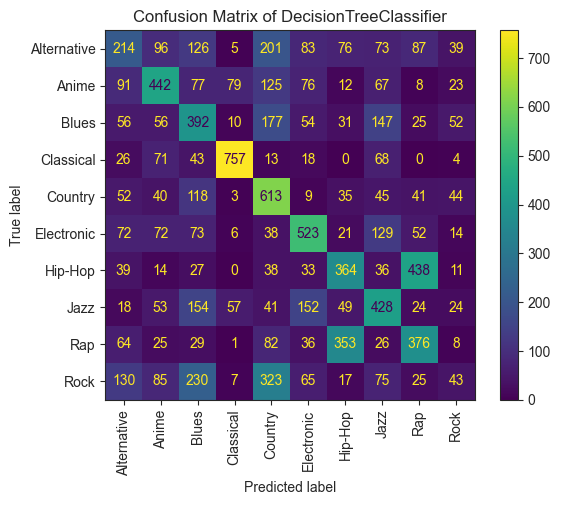

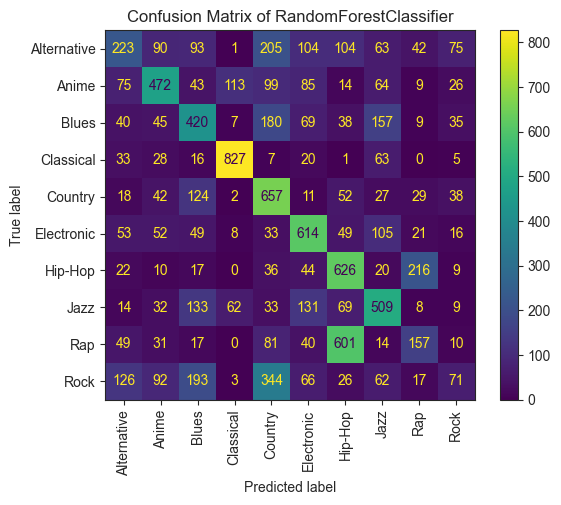

In [7]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

class_names = list(df['music_genre'].cat.categories)
models = (DecisionTreeClassifier(random_state=42, max_depth=10),
          RandomForestClassifier(max_depth=10, random_state=42))
for model in models:
    test_perfomance(model, X_train, X_test, y_train, y_test, class_names)

### З Методом Головних Компонент

Спочатку визначимо оптимальне значення компонент

In [8]:
pca = PCA(random_state=42)
X_pca = pca.fit_transform(X)
n_components = np.arange(pca.n_components_) + 1

Нижче можемо побачити графік, який називається `Scree Plot`. `Bar Chart` знизу говорить нам яка частина дисперсії "пояснюється" (виражається) кожною компонентою. В той час як лінійний графік зверху показує нам поточну сумму (`cumulative sum`) поясненої дисперсії для кожної компоненти.

Наше завдання вибрати таку кількість компонент, щоб сума поясненої дисперсії була не меншою ніж, скажімо, 95%. В моєму випадку можемо отримати таке значення використовуючи 8/9 компонент.

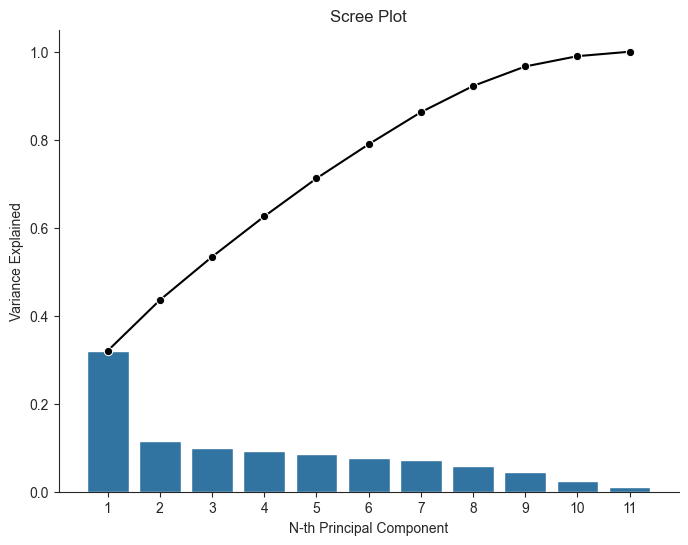

In [9]:
_ = plt.figure(figsize=(8, 6))
sns.barplot(x=n_components, y=pca.explained_variance_ratio_, color='tab:blue')
cum_exp_var = np.cumsum(pca.explained_variance_ratio_)
sns.lineplot(x=n_components - 1, y=cum_exp_var, color='black',
             marker='o', markersize=6)
plt.title('Scree Plot')
plt.xlabel('N-th Principal Component')
plt.ylabel('Variance Explained')
sns.despine()

Щоб більш точно встановити оптимальне значення головних компонент, на додачу до візуального методу, можемо це значення порахувати:

In [10]:
n_opt_comp = (cum_exp_var <= 0.95).sum()
print('Optimal N of Components:', n_opt_comp)
X_pca = X_pca[:, :n_opt_comp]

Optimal N of Components: 8


Тренуємо моделі

Accuracy of DecisionTreeClassifier: 0.3626
Accuracy of RandomForestClassifier: 0.3953


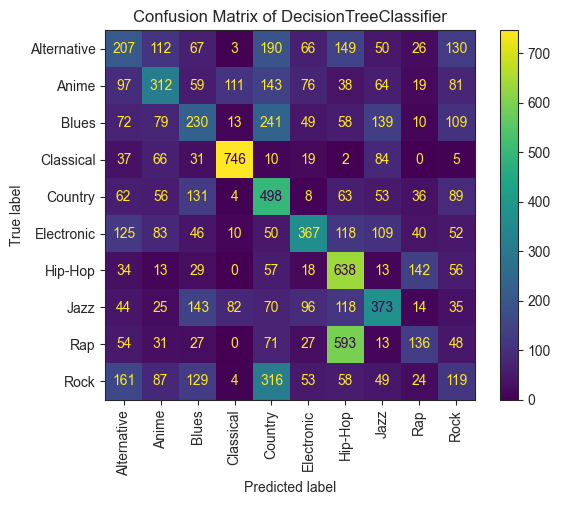

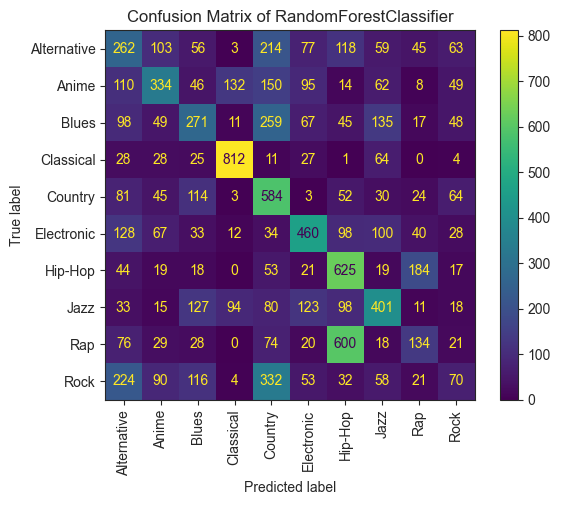

In [11]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

models = (DecisionTreeClassifier(random_state=42, max_depth=10),
          RandomForestClassifier(max_depth=10, random_state=42))
for model in models:
    test_perfomance(model, X_train, X_test, y_train, y_test, class_names)   

Як можна побачити, в моїй ситуації `PCA` знижує значення метрик, і кращі результати вдається отримати без нього.

`Random Forest` показує себе краще, ніж `Decision Tree`, що не дивно, оскільки перший, є ансаблем із 100 дерев.